## Подготовка.

In [1]:
import numpy as np
import pandas as pd

from CONSTANTS import KEYS, MONTHS, YEARS, TARGET_COLUMN
import parse_csvs
import realised_volatility

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

In [2]:
sns.set_theme()

In [3]:
CV = TimeSeriesSplit()
SCORER = 'neg_root_mean_squared_error'

In [4]:
KEY = KEYS[0]
START_DATE = '2001-01-01'
EXP_DATE = '2022-12-15'

## Загрузка

In [5]:
data = pd.DataFrame()

In [6]:
results = []

In [7]:
for year in YEARS:
    for month in MONTHS:
        name = KEY + '-' + month + '.' + year
        try:
            result, riu2 = parse_csvs.parse(name)
            results.append(result)
        except:
            pass
        try:
            riu2.index = riu2.index.to_period("D")
        except:
            pass
        try:
            riu2 = riu2[[TARGET_COLUMN]]
        except:
            pass
        try:
            riu2['name'] = name
        except:
            pass
        try:
            riu2 = realised_volatility.compute(riu2)
        except:
            pass
        try:
            riu2 = riu2[START_DATE:]
        except:
            pass
        try:
            START_DATE = str(riu2.index[riu2.shape[0]-1].year) + '-' + str(riu2.index[riu2.shape[0]-1].month) \
            + '-' + str(riu2.index[riu2.shape[0]-1].day+1)
        except:
            pass
        try:
            data = pd.concat([data, riu2])
        except:
            pass

## Проверка

In [8]:
x = pd.DataFrame(results)

In [9]:
x = x.fillna(0)

In [10]:
x.head()

,name,read_scv,columns,to_datetime,sort_values,set_index
0,RTS-3.01,False,0,0,0,0
1,RTS-6.01,False,0,0,0,0
2,RTS-9.01,False,0,0,0,0
3,RTS-12.01,False,0,0,0,0
4,RTS-3.02,False,0,0,0,0


In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         88 non-null     object
 1   read_scv     88 non-null     bool  
 2   columns      88 non-null     object
 3   to_datetime  88 non-null     object
 4   sort_values  88 non-null     object
 5   set_index    88 non-null     object
dtypes: bool(1), object(5)
memory usage: 3.6+ KB


In [12]:
x[x['read_scv']]['name'].unique()

array(['RTS-9.05', 'RTS-12.05', 'RTS-3.06', 'RTS-6.06', 'RTS-9.06',
       'RTS-12.06', 'RTS-3.07', 'RTS-6.07', 'RTS-9.07', 'RTS-12.07',
       'RTS-3.08', 'RTS-6.08', 'RTS-9.08', 'RTS-12.08', 'RTS-3.09',
       'RTS-6.09', 'RTS-9.09', 'RTS-12.09', 'RTS-3.10', 'RTS-6.10',
       'RTS-9.10', 'RTS-12.10', 'RTS-3.11', 'RTS-6.11', 'RTS-9.11',
       'RTS-12.11', 'RTS-3.12', 'RTS-6.12', 'RTS-9.12', 'RTS-12.12',
       'RTS-3.13', 'RTS-6.13', 'RTS-9.13', 'RTS-12.13', 'RTS-3.14',
       'RTS-6.14', 'RTS-9.14', 'RTS-12.14', 'RTS-3.15', 'RTS-6.15',
       'RTS-9.15', 'RTS-12.15', 'RTS-3.16', 'RTS-6.16', 'RTS-9.16',
       'RTS-12.16', 'RTS-3.17', 'RTS-6.17', 'RTS-9.17', 'RTS-12.17',
       'RTS-3.18', 'RTS-6.18', 'RTS-9.18', 'RTS-12.18', 'RTS-3.19',
       'RTS-6.19', 'RTS-9.19', 'RTS-12.19', 'RTS-3.20', 'RTS-6.20',
       'RTS-9.20', 'RTS-12.20', 'RTS-3.21', 'RTS-6.21', 'RTS-9.21',
       'RTS-12.21', 'RTS-3.22', 'RTS-6.22', 'RTS-9.22', 'RTS-12.22'],
      dtype=object)

In [13]:
x[x['read_scv']].drop(['name'], axis = 1).mean()*100

read_scv       100.0
columns        100.0
to_datetime    100.0
sort_values    100.0
set_index      100.0
dtype: float64

In [14]:
data.head(10)

,name,adjp,mov_5,mov_10,mov_20,mov_40,mov_60,mov_120,mov_240,lag_1,dif_1,return,ln_r,volatility_5,volatility_20,volatility_60
2005-08-03,RTS-9.05,79810.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-04,RTS-9.05,80270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79810.0,460.0,1.005764,0.005747,NaN,NaN,NaN
2005-08-05,RTS-9.05,81050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80270.0,780.0,1.009717,0.009670,NaN,NaN,NaN
2005-08-08,RTS-9.05,81610.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81050.0,560.0,1.006909,0.006886,NaN,NaN,NaN
2005-08-09,RTS-9.05,81515.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81610.0,-95.0,0.998836,-0.001165,NaN,NaN,NaN
2005-08-10,RTS-9.05,81715.0,80851.0,NaN,NaN,NaN,NaN,NaN,NaN,81515.0,200.0,1.002454,0.002451,6.746855,NaN,NaN
2005-08-11,RTS-9.05,81050.0,81232.0,NaN,NaN,NaN,NaN,NaN,NaN,81715.0,-665.0,0.991862,-0.008171,11.297379,NaN,NaN
2005-08-12,RTS-9.05,81000.0,81388.0,NaN,NaN,NaN,NaN,NaN,NaN,81050.0,-50.0,0.999383,-0.000617,8.899505,NaN,NaN
2005-08-15,RTS-9.05,81595.0,81378.0,NaN,NaN,NaN,NaN,NaN,NaN,81000.0,595.0,1.007346,0.007319,9.123961,NaN,NaN
2005-08-16,RTS-9.05,84060.0,81375.0,NaN,NaN,NaN,NaN,NaN,NaN,81595.0,2465.0,1.030210,0.029763,23.136191,NaN,NaN


In [15]:
data.tail()

,name,adjp,mov_5,mov_10,mov_20,mov_40,mov_60,mov_120,mov_240,lag_1,dif_1,return,ln_r,volatility_5,volatility_20,volatility_60
2022-12-09,RTS-12.22,109890.0,110390.0,111376.0,112559.5,110053.00,107955.500000,109286.750000,112470.041667,109720.0,170.0,1.001549,0.001548,15.753156,17.515427,35.153537
2022-12-12,RTS-12.22,109130.0,110230.0,111032.0,112331.0,110330.25,107862.333333,109190.750000,112287.750000,109890.0,-760.0,0.993084,-0.006940,13.158056,17.190332,35.167465
2022-12-13,RTS-12.22,109050.0,109730.0,110775.0,112020.0,110583.25,107751.000000,109090.500000,112097.125000,109130.0,-80.0,0.999267,-0.000733,6.880462,16.690388,35.116052
2022-12-14,RTS-12.22,106740.0,109590.0,110413.0,111783.5,110714.25,107622.833333,108957.916667,111914.833333,109050.0,-2310.0,0.978817,-0.021411,14.570155,17.261594,30.914817
2022-12-15,RTS-12.22,103915.0,108906.0,109873.0,111367.5,110794.00,107610.500000,108764.916667,111722.916667,106740.0,-2825.0,0.973534,-0.026823,20.364182,18.979075,30.561054


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4360 entries, 2005-08-03 to 2022-12-15
Freq: D
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4360 non-null   object 
 1   adjp           4359 non-null   float64
 2   mov_5          4355 non-null   float64
 3   mov_10         4350 non-null   float64
 4   mov_20         4340 non-null   float64
 5   mov_40         4320 non-null   float64
 6   mov_60         4294 non-null   float64
 7   mov_120        3730 non-null   float64
 8   mov_240        2638 non-null   float64
 9   lag_1          4359 non-null   float64
 10  dif_1          4358 non-null   float64
 11  return         4359 non-null   float64
 12  ln_r           4359 non-null   float64
 13  volatility_5   4355 non-null   float64
 14  volatility_20  4340 non-null   float64
 15  volatility_60  4294 non-null   float64
dtypes: float64(15), object(1)
memory usage: 579.1+ KB


In [17]:
data.isna().sum().sort_values(ascending = False)

mov_240          1722
mov_120           630
mov_60             66
volatility_60      66
mov_40             40
mov_20             20
volatility_20      20
mov_10             10
mov_5               5
volatility_5        5
dif_1               2
adjp                1
lag_1               1
return              1
ln_r                1
name                0
dtype: int64

In [18]:
data = data.sort_index()

In [19]:
data.index.is_monotonic

True

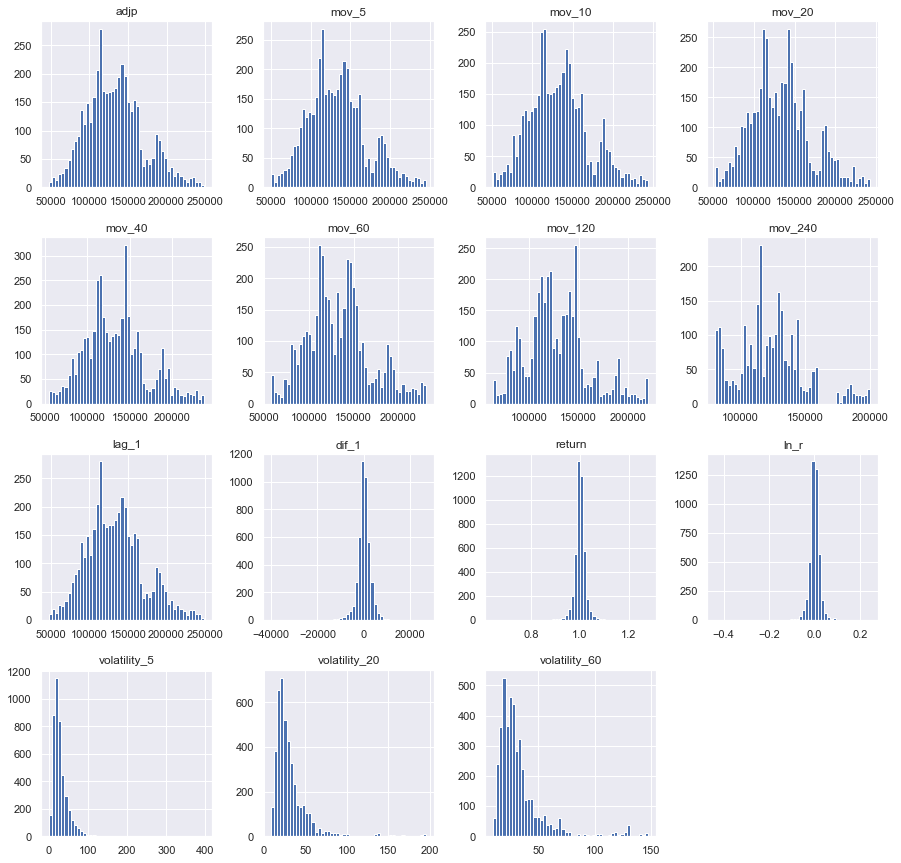

In [20]:
data.hist(bins = 50, figsize = (15, 15))
plt.show()

In [21]:
data.describe()

,adjp,mov_5,mov_10,mov_20,mov_40,mov_60,mov_120,mov_240,lag_1,dif_1,return,ln_r,volatility_5,volatility_20,volatility_60
count,4359.000000,4355.000000,4350.00000,4340.000000,4320.000000,4294.000000,3730.000000,2638.000000,4359.000000,4358.000000,4359.000000,4359.000000,4355.000000,4340.000000,4294.000000
mean,133487.162881,133462.873938,133463.35954,133468.733065,133489.351157,133430.559599,128075.605451,123073.202394,133462.923836,26.442864,1.000531,0.000239,29.963777,32.150681,33.292936
std,36968.352118,36899.803490,36816.46000,36653.747154,36318.483918,35871.823231,31764.646454,25943.048115,36977.122735,2840.939355,0.023986,0.024282,25.699803,23.144384,21.528762
min,47700.000000,49875.000000,51748.00000,52968.750000,54481.500000,57738.250000,63564.208333,80222.000000,47700.000000,-40030.000000,0.645658,-0.437485,0.000000,8.666056,10.082846
25%,108225.000000,108299.000000,108616.25000,109070.500000,109284.937500,109868.583333,108396.458333,106618.385417,108200.000000,-1210.000000,0.990543,-0.009502,16.236048,19.506928,20.518342
50%,130780.000000,130740.000000,131241.00000,131567.250000,131011.125000,131430.000000,123290.583333,121478.291667,130760.000000,75.000000,1.000563,0.000563,23.730477,25.512556,27.506031
75%,155150.000000,154883.000000,154446.12500,154773.625000,153520.375000,152011.854167,145510.260417,137065.468750,155150.000000,1470.000000,1.011134,0.011073,35.328488,36.314751,36.629590
max,248900.000000,245736.000000,243857.00000,242850.000000,238106.250000,231154.833333,220556.625000,200670.812500,248900.000000,27010.000000,1.280478,0.247233,396.875790,195.699823,147.300090


## EDA

<AxesSubplot:>

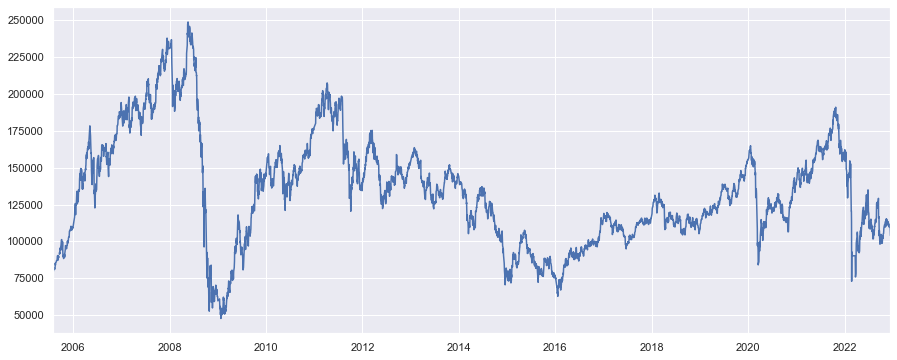

In [22]:
data[TARGET_COLUMN].plot(figsize = (15, 6))

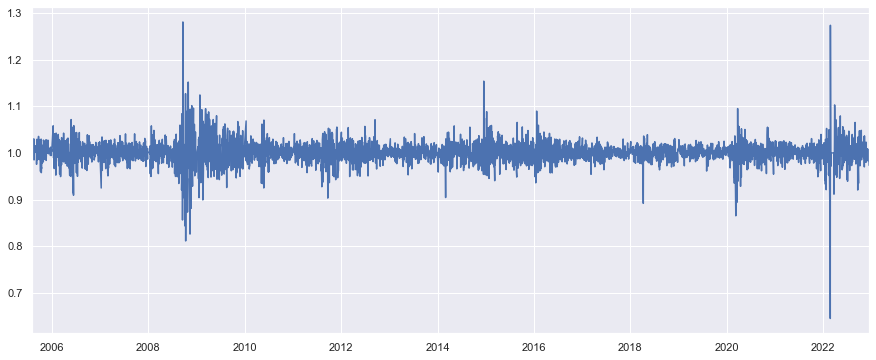

In [23]:
try:
    data['return'].plot(figsize = (15, 6))
except:
    print('no return plot')

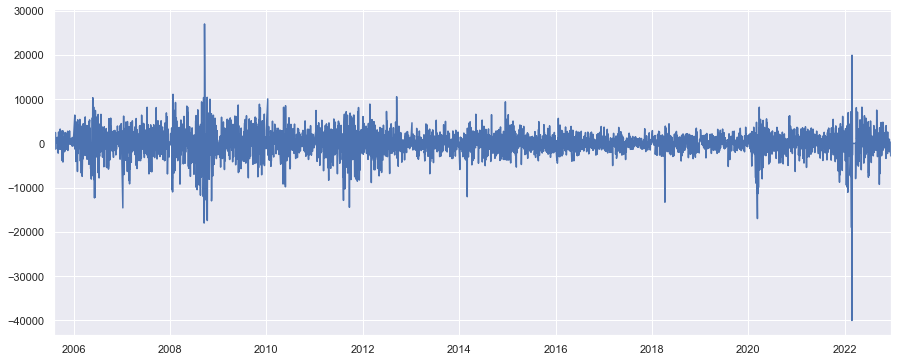

In [24]:
try:
    data['dif_1'].plot(figsize = (15, 6))
except:
    print('no dif_1 plot')

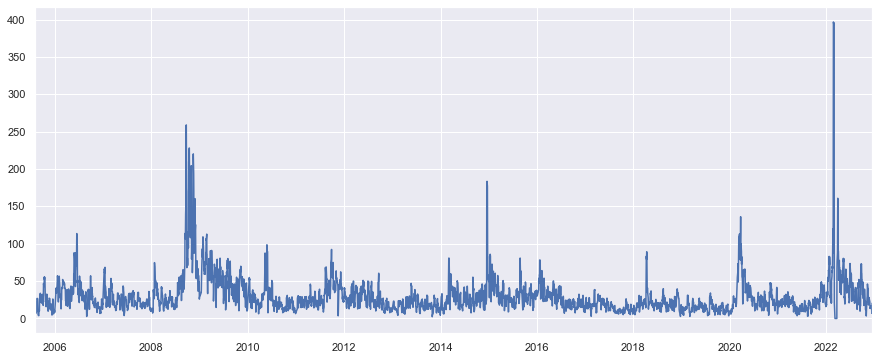

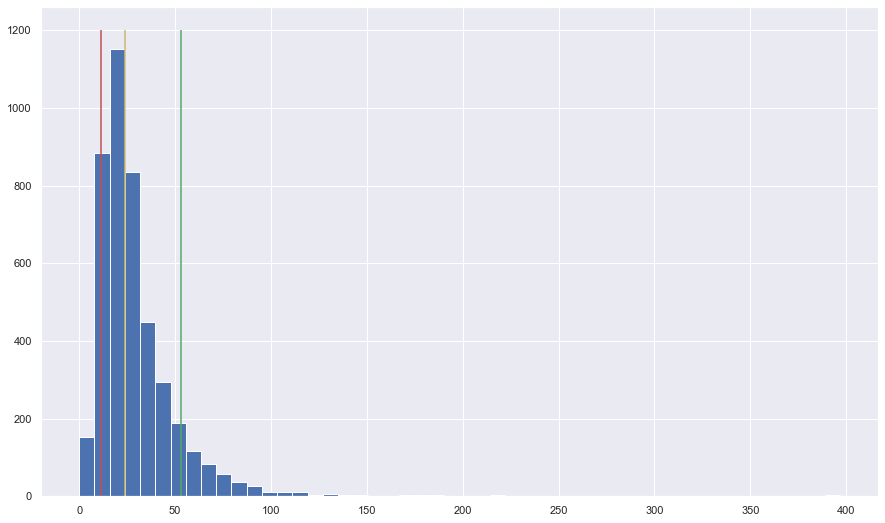

low: 11.18, med: 23.73, upp: 53.30


In [25]:
try:
    x = data['volatility_5']
    x.plot(figsize = (15, 6))
    plt.show()
    low = x.quantile(.1)
    med = x.median()
    upp = x.quantile(.9)
    x.hist(bins = 50, figsize = (15, 9), color = 'b')
    plt.vlines(low, 0, 1200, color = 'r')
    plt.vlines(med, 0, 1200, color = 'y')
    plt.vlines(upp, 0, 1200, color = 'g')
    plt.show()
    print('low: {:.2f}, med: {:.2f}, upp: {:.2f}'.format(low, med, upp))
except:
    print('no vol_5')

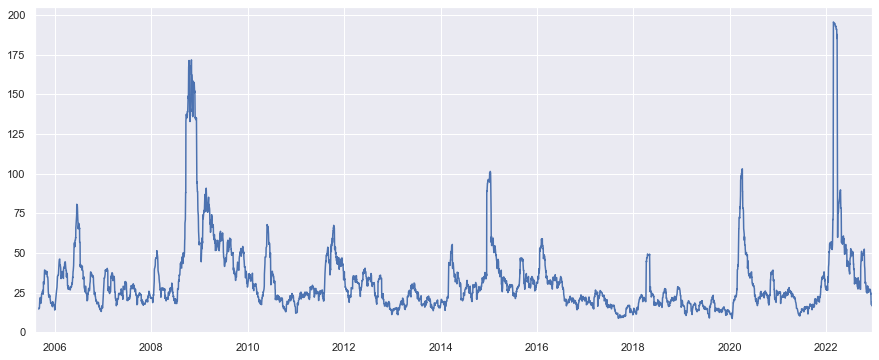

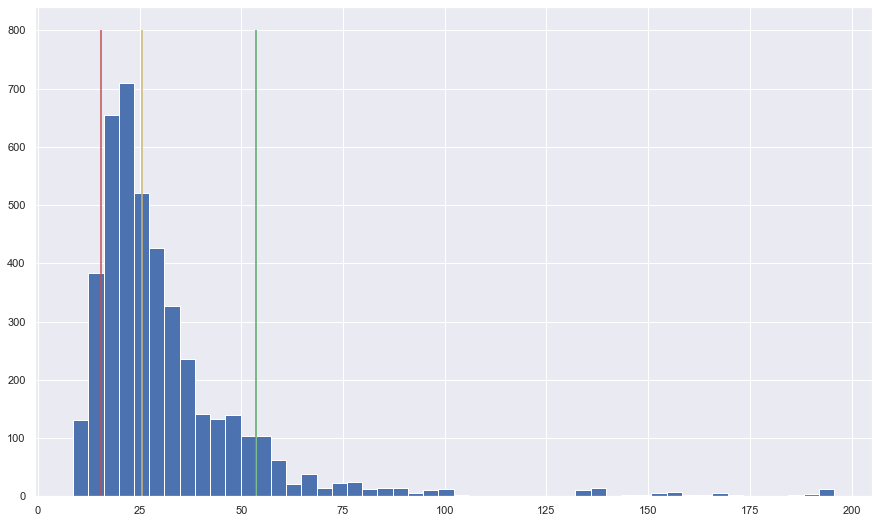

low: 15.55, med: 25.51, upp: 53.63


In [26]:
try:
    x = data['volatility_20']
    x.plot(figsize = (15, 6))
    plt.show()
    low = x.quantile(.1)
    med = x.median()
    upp = x.quantile(.9)
    x.hist(bins = 50, figsize = (15, 9), color = 'b')
    plt.vlines(low, 0, 800, color = 'r')
    plt.vlines(med, 0, 800, color = 'y')
    plt.vlines(upp, 0, 800, color = 'g')
    plt.show()
    print('low: {:.2f}, med: {:.2f}, upp: {:.2f}'.format(low, med, upp))
except:
    print('no vol_20')

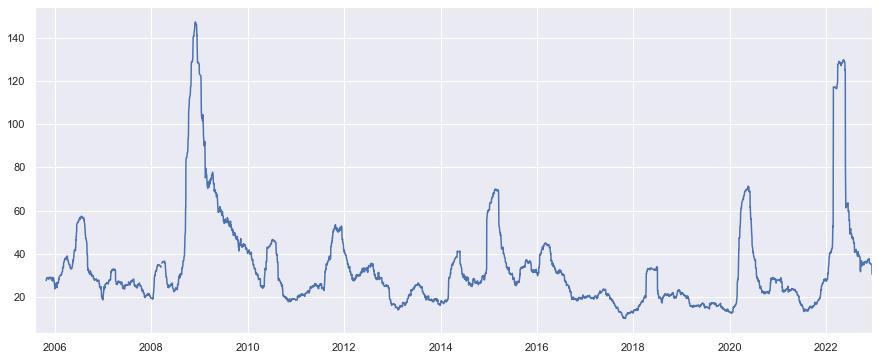

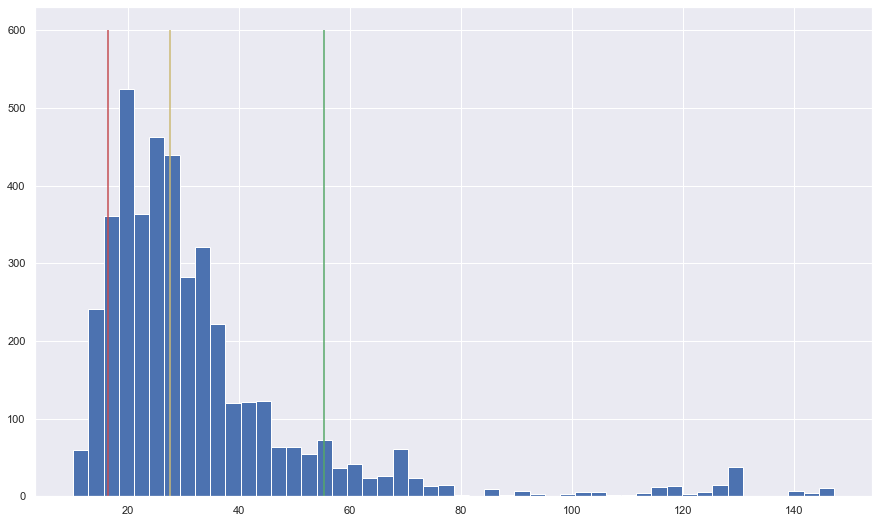

low: 16.37, med: 27.51, upp: 55.41


In [27]:
try:
    x = data['volatility_60']
    x.plot(figsize = (15, 6))
    plt.show()
    low = x.quantile(.1)
    med = x.median()
    upp = x.quantile(.9)
    x.hist(bins = 50, figsize = (15, 9), color = 'b')
    plt.vlines(low, 0, 600, color = 'r')
    plt.vlines(med, 0, 600, color = 'y')
    plt.vlines(upp, 0, 600, color = 'g')
    plt.show()
    print('low: {:.2f}, med: {:.2f}, upp: {:.2f}'.format(low, med, upp))
except:
    print('no vol_60')

Автокорреляция цен.

In [28]:
acf = []
for i in range(1, 1000, 1):
    acf.append({'i': i, 'corr': data[TARGET_COLUMN].corr(data[TARGET_COLUMN].shift(i))})

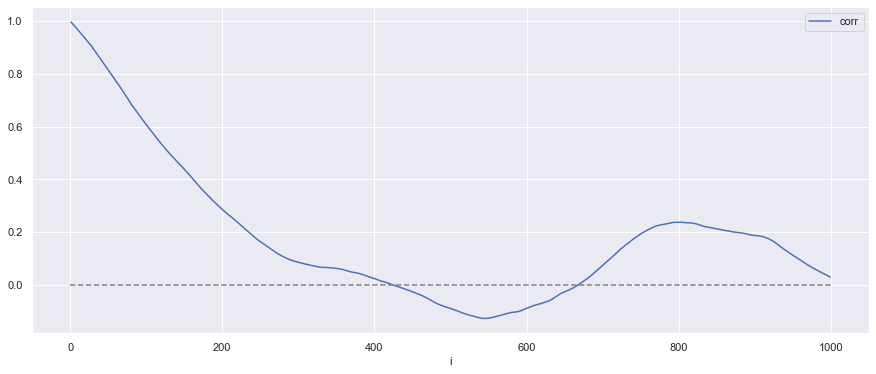

In [29]:
pd.DataFrame(acf).set_index('i').plot(figsize = (15, 6))
plt.hlines(0, 0, 1000, linestyles='dashed', color = 'grey')
plt.show()

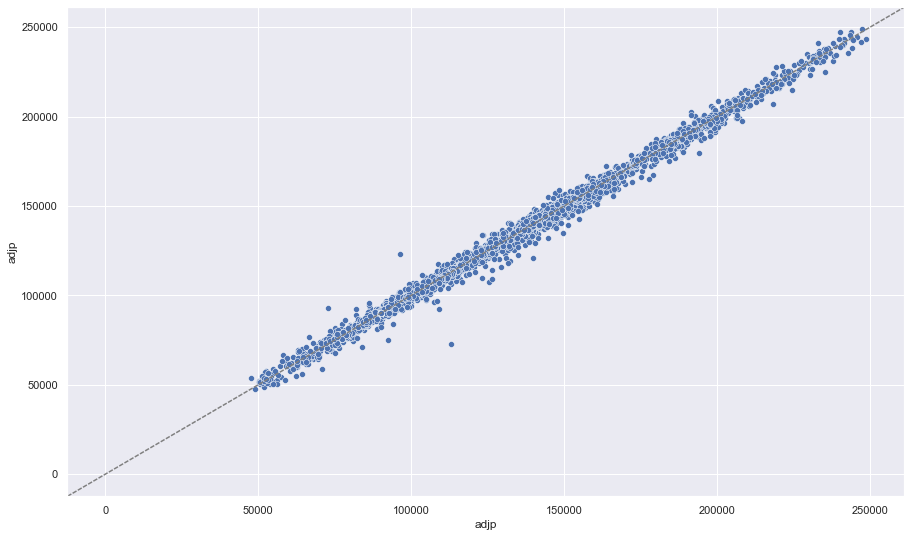

In [30]:
x1 = data[TARGET_COLUMN].shift()
y1 = data[TARGET_COLUMN]
f, ax = plt.subplots(figsize = (15, 9))
plt.axline((0, 0), (1, 1), dashes = (3, 1), color = 'grey')
sns.scatterplot(x = x1, y = y1, ax = ax)
plt.show()

Автокорреляция доходностей.

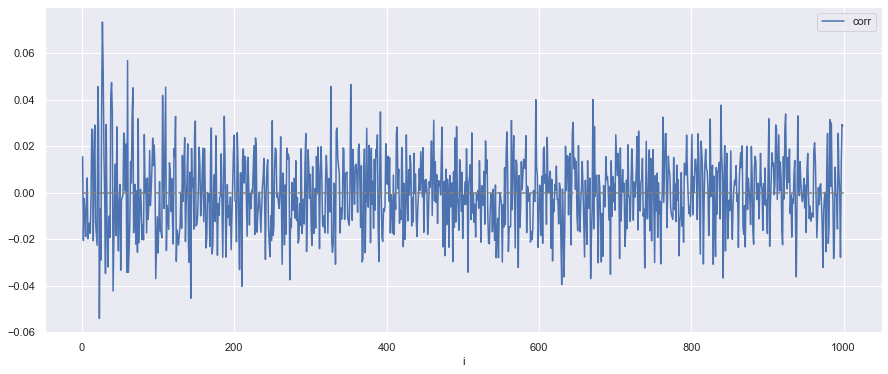

In [31]:
acf1 = []
for i in range(1, 1000, 1):
    acf1.append({'i': i, 'corr': data['return'].corr(data['return'].shift(i))})

pd.DataFrame(acf1).set_index('i').plot(figsize = (15, 6))
plt.hlines(0, 1, 1000, linestyles='dashed', color = 'grey')
plt.show()

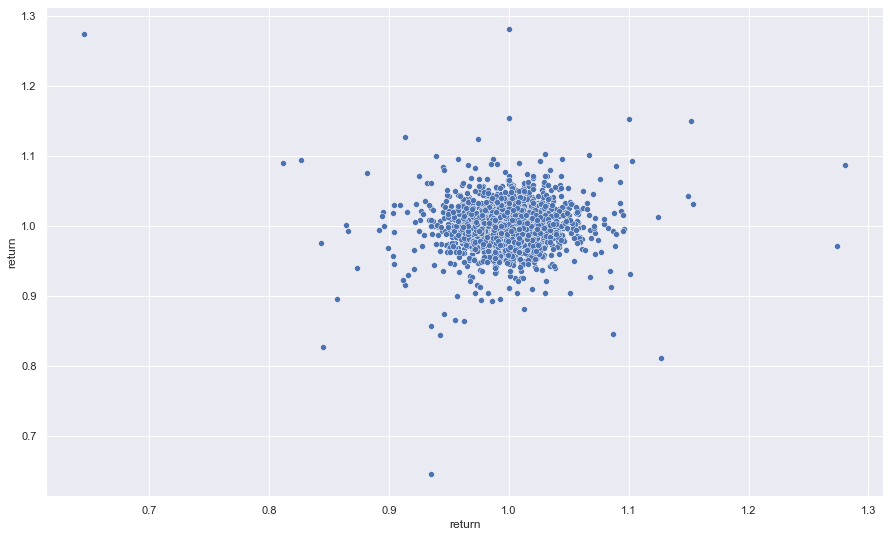

In [32]:
x1 = data['return'].shift()
y1 = data['return']
f, ax = plt.subplots(figsize = (15, 9))
sns.scatterplot(x = x1, y = y1, ax = ax)
plt.show()

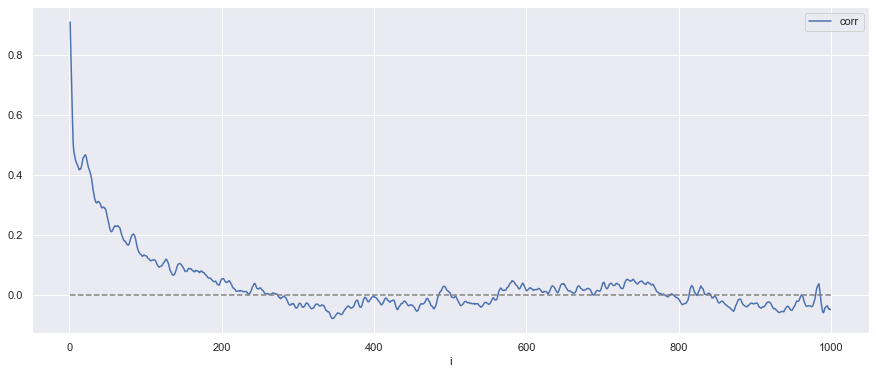

In [33]:
acf2 = []
for i in range(1, 1000, 1):
    acf2.append({'i': i, 'corr': data['volatility_5'].corr(data['volatility_5'].shift(i))})

pd.DataFrame(acf2).set_index('i').plot(figsize = (15, 6))
plt.hlines(0, 1, 1000, linestyles='dashed', color = 'grey')
plt.show()

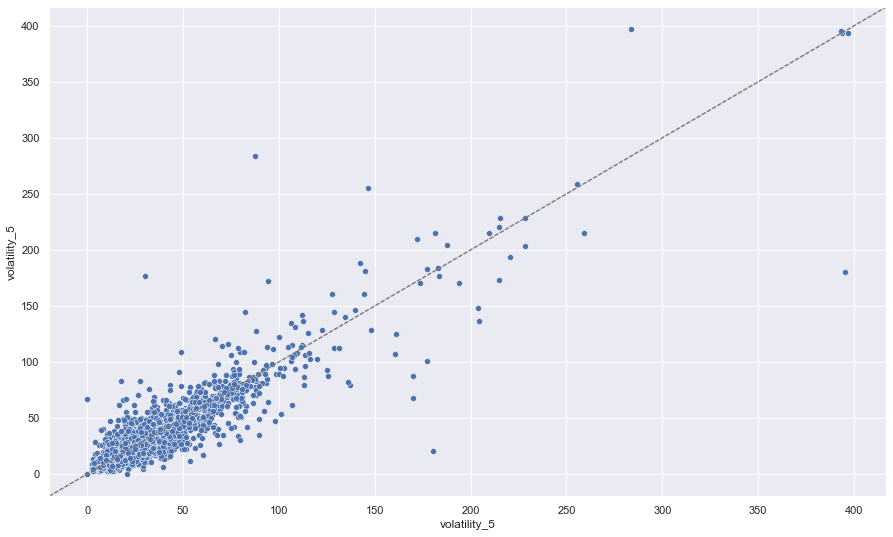

In [34]:
x1 = data['volatility_5'].shift()
y1 = data['volatility_5']
f, ax = plt.subplots(figsize = (15, 9))
plt.axline((0, 0), (1, 1), dashes = (3, 1), color = 'grey')
sns.scatterplot(x = x1, y = y1, ax = ax)
plt.show()

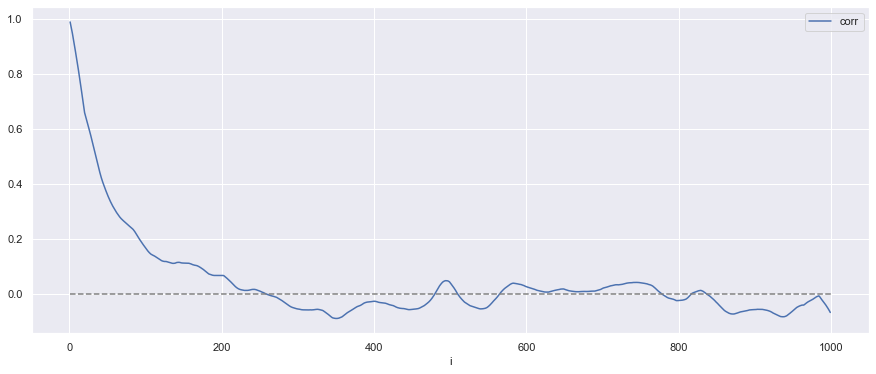

In [35]:
acf2 = []
for i in range(1, 1000, 1):
    acf2.append({'i': i, 'corr': data['volatility_20'].corr(data['volatility_20'].shift(i))})

pd.DataFrame(acf2).set_index('i').plot(figsize = (15, 6))
plt.hlines(0, 1, 1000, linestyles='dashed', color = 'grey')
plt.show()

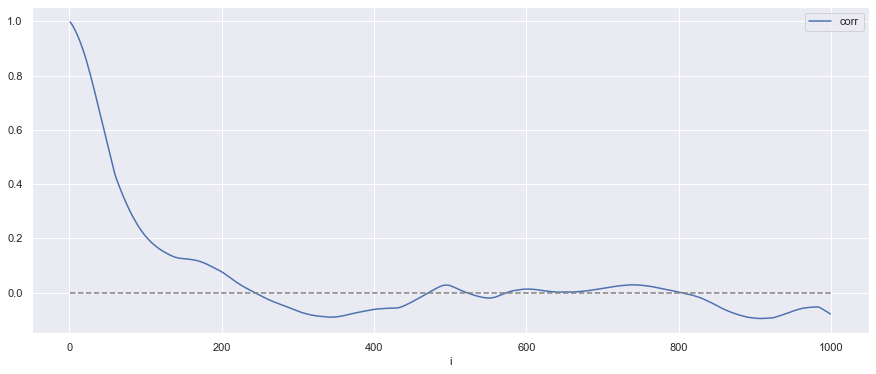

In [36]:
acf2 = []
for i in range(1, 1000, 1):
    acf2.append({'i': i, 'corr': data['volatility_60'].corr(data['volatility_60'].shift(i))})

pd.DataFrame(acf2).set_index('i').plot(figsize = (15, 6))
plt.hlines(0, 1, 1000, linestyles='dashed', color = 'grey')
plt.show()

Аппроксимация линейной регрессией.

Дамми модели:

In [37]:
model = LinearRegression()

In [38]:
y = data[TARGET_COLUMN].dropna()

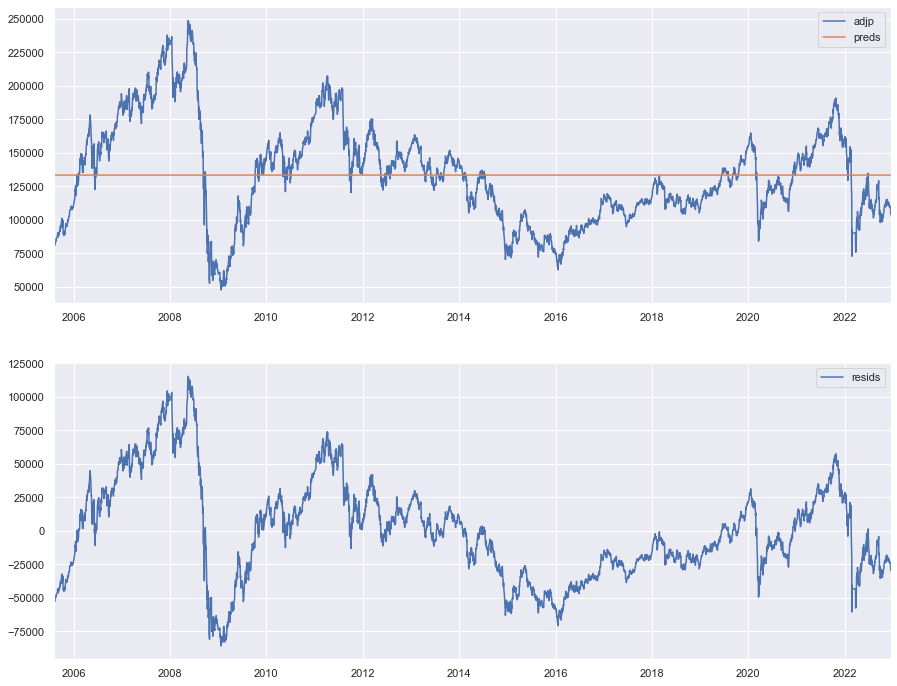

mean RMSE: 36964.11
median R2: 0.0


In [39]:
preds_mean = pd.DataFrame(np.ones(y.shape[0]) * y.mean(), index = y.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds_mean.plot(ax = ax[0], legend = True)
(y - preds_mean['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('mean RMSE: {:.2f}'.format(mean_squared_error(y, preds_mean)**0.5))
print('median R2:', r2_score(y, preds_mean))

Используем шаг по времени:

In [40]:
model = LinearRegression()

In [41]:
y = data[TARGET_COLUMN].dropna()

In [42]:
X = pd.DataFrame(np.arange(len(y.index)), index = y.index, columns = ['X'])

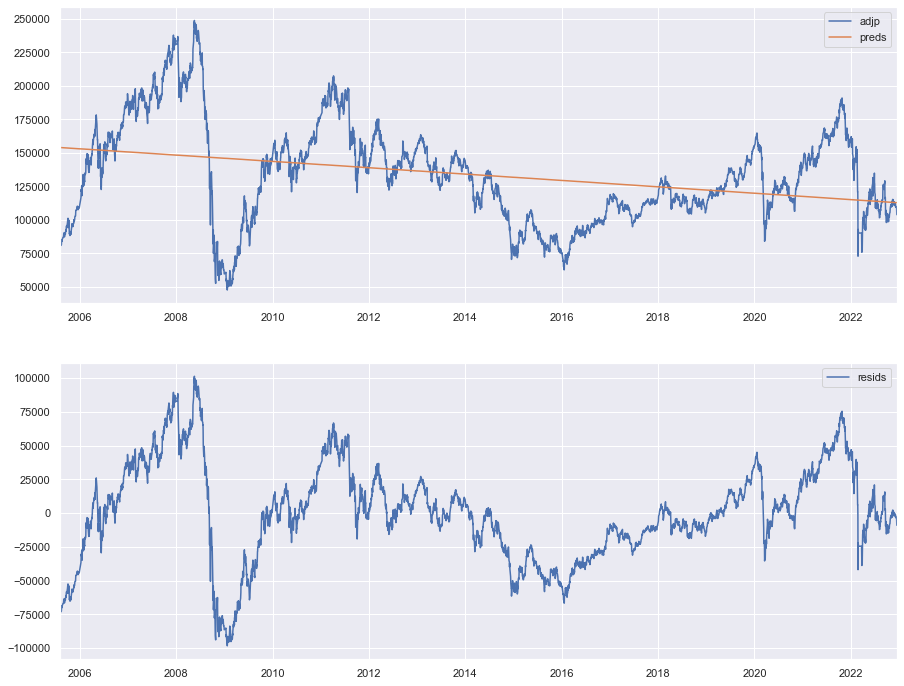

RMSE: 34999.17
R2: 0.10


In [43]:
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

Применим Determenistic process

In [44]:
model = LinearRegression()

In [45]:
y = data[TARGET_COLUMN].dropna()

In [46]:
dp = DeterministicProcess(
    index = y.index,  # dates from the training data
    constant = True,       # dummy feature for the bias (y_intercept)
    order = 1,             # the time dummy (trend)
    drop = True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

In [47]:
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])

In [48]:
X = dp.out_of_sample(steps=60)

In [49]:
y_fore = pd.DataFrame(model.predict(X), index = X.index, columns = ['forecast'])

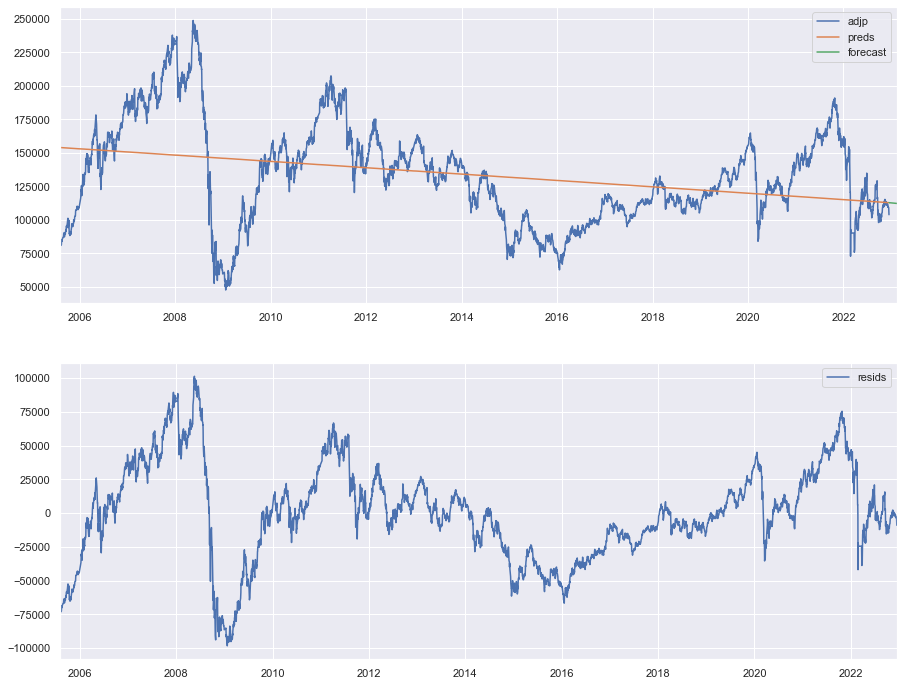

RMSE: 34999.17
R2: 0.10


In [50]:
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
y_fore.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

Применим скользящее среднее:

In [51]:
model = LinearRegression()

In [52]:
y = data[TARGET_COLUMN].shift(-1).dropna()

In [53]:
X = data[[TARGET_COLUMN]].rolling(5).mean()

In [54]:
X = X.dropna()

In [55]:
y, X = y.align(X, join='inner', axis = 0)

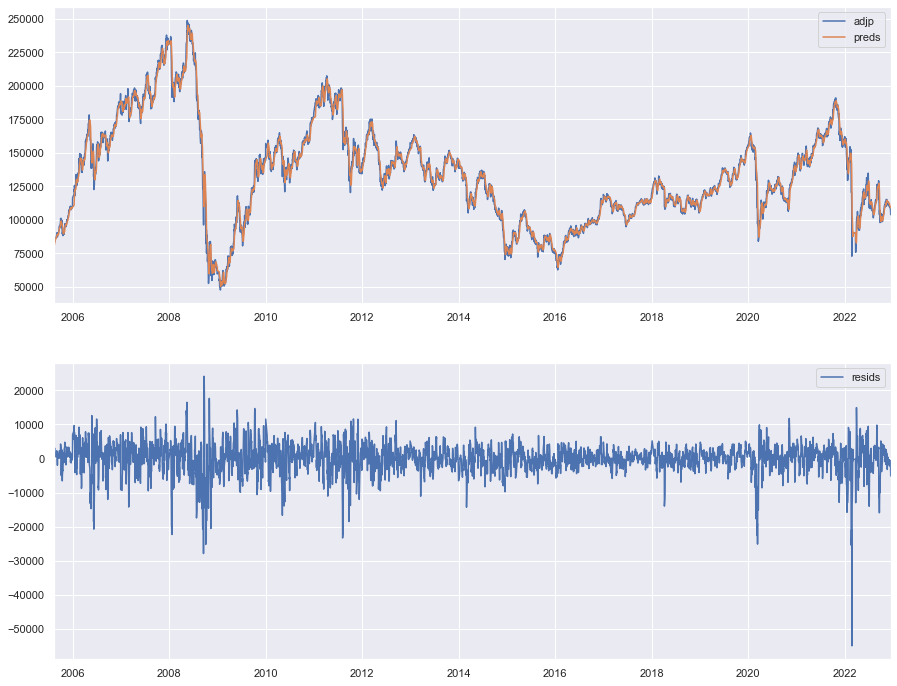

RMSE: 4332.47
R2: 0.99


In [56]:
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

кросс - валидация ск среднего

In [57]:
cross_val_score(model, X, y, cv = CV, scoring = 'r2').mean()

0.964198192663854

Предсказание предыдущим значением ряда:

In [58]:
model = LinearRegression()

In [59]:
y = data[TARGET_COLUMN].dropna()

In [60]:
X = data[['lag_1']].dropna()

In [61]:
y, X = y.align(X, join='inner', axis = 0)

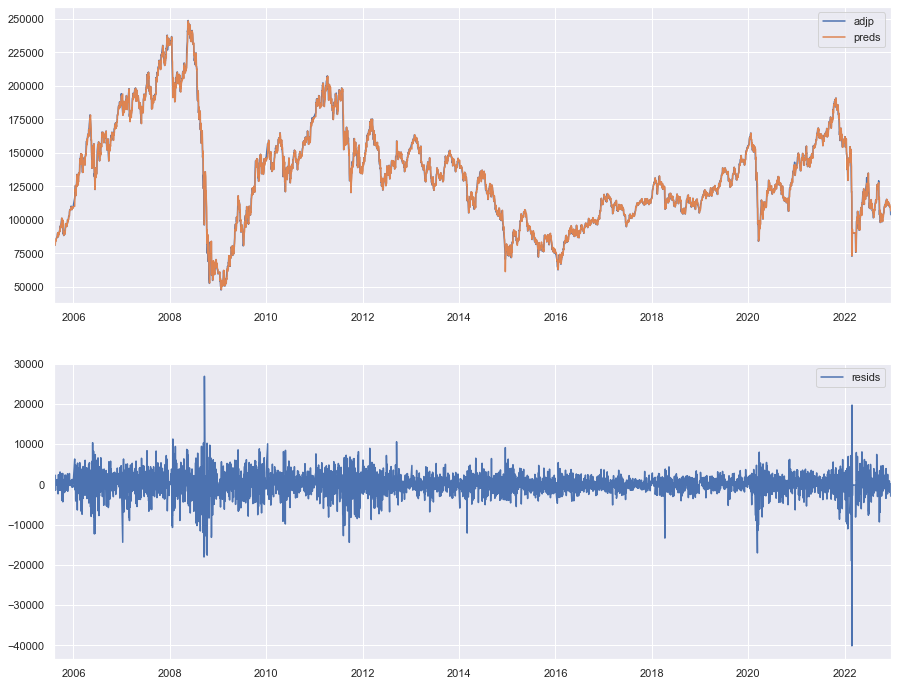

RMSE: 2838.04
R2: 0.99


In [62]:
model.fit(X, y)
preds = pd.DataFrame(model.predict(X), index = X.index, columns = ['preds'])
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
(y - preds['preds']).plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

<AxesSubplot:>

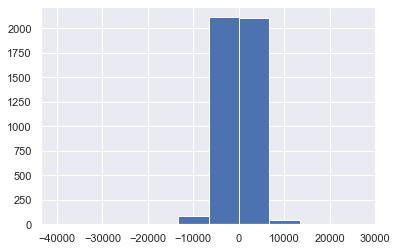

In [63]:
(y - preds['preds']).hist()

In [64]:
(y - preds['preds']).describe()

count    4.358000e+03
mean    -2.925075e-12
std      2.838369e+03
min     -4.012344e+04
25%     -1.232317e+03
50%      3.652814e+01
75%      1.409977e+03
max      2.686209e+04
dtype: float64

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [66]:
model.fit(X_train, y_train)

LinearRegression()

In [67]:
preds = model.predict(X_test)

In [68]:
print('RMSE: {:.2f}'.format(mean_squared_error(y_test, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y_test, preds)))

RMSE: 4469.11
R2: 0.90


Переходим к Фурье

In [69]:
model = LinearRegression()

In [70]:
y = data[TARGET_COLUMN].dropna()

In [71]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [72]:
fourier = fourier_features(y, freq=365, order=4)

<AxesSubplot:xlabel='adjp'>

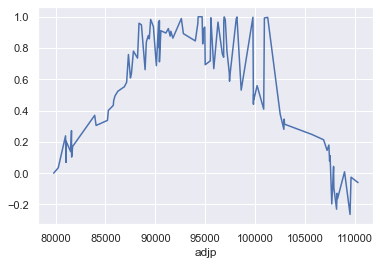

In [73]:
fourier.iloc[:100, 2].sort_index().plot()

In [74]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

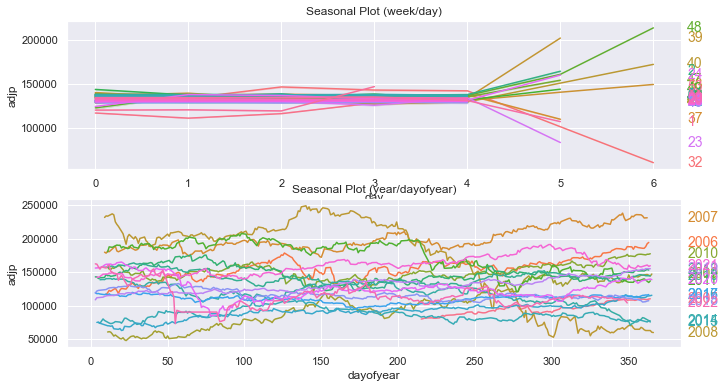

In [75]:
X = data.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y=TARGET_COLUMN, period="week", freq="day", ax=ax0)
seasonal_plot(X, y=TARGET_COLUMN, period="year", freq="dayofyear", ax=ax1);

In [76]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_69205/3030094478.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(y)


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

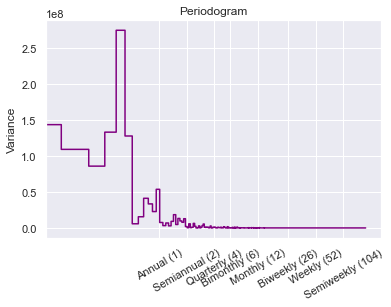

In [77]:
plot_periodogram(y)

In [78]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

In [79]:
fourier

Fourier(freq=A-DEC, order=10) at 0x7f8833da6e80

In [80]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4359 entries, 2005-08-03 to 2022-12-15
Freq: D
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   const               4359 non-null   float64
 1   trend               4359 non-null   float64
 2   s(2,7)              4359 non-null   float64
 3   s(3,7)              4359 non-null   float64
 4   s(4,7)              4359 non-null   float64
 5   s(5,7)              4359 non-null   float64
 6   s(6,7)              4359 non-null   float64
 7   s(7,7)              4359 non-null   float64
 8   sin(1,freq=A-DEC)   4359 non-null   float64
 9   cos(1,freq=A-DEC)   4359 non-null   float64
 10  sin(2,freq=A-DEC)   4359 non-null   float64
 11  cos(2,freq=A-DEC)   4359 non-null   float64
 12  sin(3,freq=A-DEC)   4359 non-null   float64
 13  cos(3,freq=A-DEC)   4359 non-null   float64
 14  sin(4,freq=A-DEC)   4359 non-null   float64
 15  cos(4,freq=A-DEC)   4359 non-nu

<AxesSubplot:>

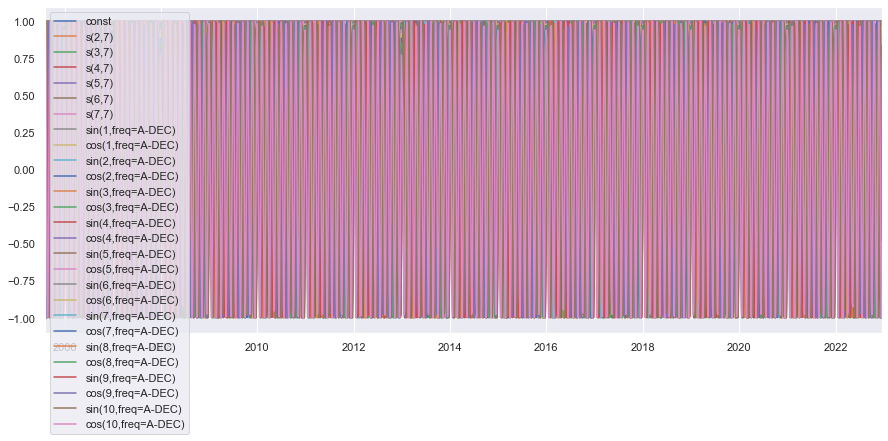

In [82]:
X.drop('trend', axis = 1).plot(figsize = (15, 6))

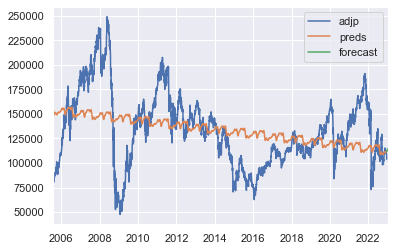

In [83]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

preds = pd.Series(model.predict(X), index=X.index)
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot()
ax = preds.plot(ax=ax, label="preds")
ax = y_fore.plot(ax=ax, label="forecast")
_ = ax.legend()

<AxesSubplot:>

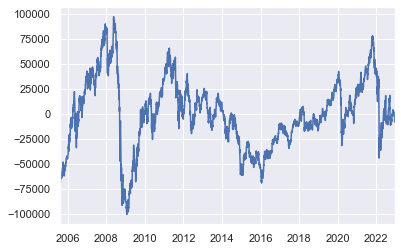

In [84]:
deseased = (y - preds)
deseased.plot()

In [85]:
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

RMSE: 34872.49
R2: 0.11


/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_69205/3892376015.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(deseased)


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

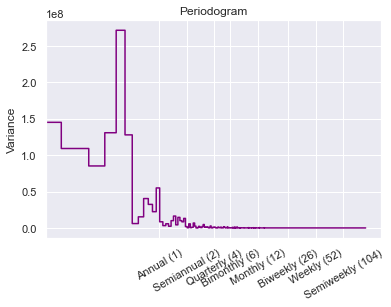

In [86]:
plot_periodogram(deseased)

## Feature eng.

In [87]:
# константа и тренд
data['const'] = np.ones(data.shape[0])
data['time_step'] = np.arange(len(data.index))
# сезонность
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['sin_month'] = np.sin(2 * np.pi * data.index.month / 12)
data['cos_month'] = np.cos(2 * np.pi * data.index.month / 12)
data['sin_day'] = np.sin(2 * np.pi * data.index.day / (365/12))
data['cos_day'] = np.cos(2 * np.pi * data.index.day / (365/12))
data['sin_dw'] = np.sin(2 * np.pi * data.index.dayofweek / 4)
data['cos_dw'] = np.cos(2 * np.pi * data.index.dayofweek / 4)

Годовая сезонность

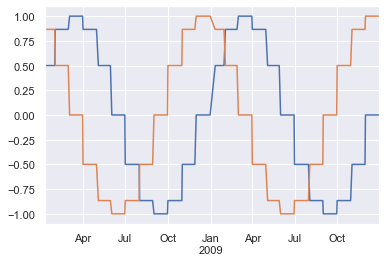

In [88]:
try:
    data['2008':'2009']['sin_month'].plot()
    data['2008':'2009']['cos_month'].plot()
    plt.show()
except:
    pass

In [89]:
try:
    data['2008':'2009']['sin_2_month'].plot()
    data['2008':'2009']['cos_2_month'].plot()
    plt.show()
except:
    pass

In [90]:
try:
    data['2008':'2009']['sin_4_month'].plot()
    data['2008':'2009']['cos_4_month'].plot()
    plt.show()
except:
    pass

Месячная сезонность

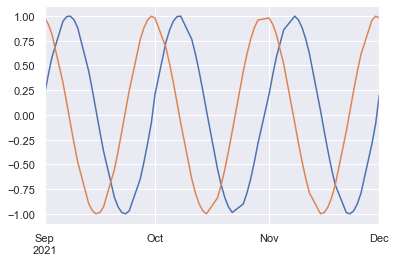

In [91]:
try:
    data['2021-09-01':'2021-12-01']['sin_day'].plot()
    data['2021-09-01':'2021-12-01']['cos_day'].plot()
    plt.show()
except:
    pass

Недельная сезонность

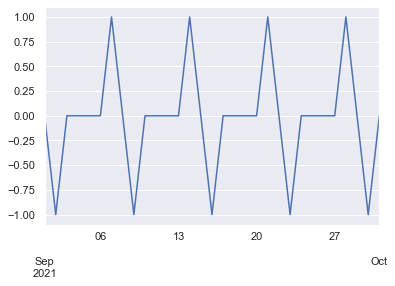

In [92]:
try:
    data['2021-09-01':'2021-10-01']['sin_dw'].plot()
    plt.show()
except:
    pass

Линейная регресия с признаками ряда (без признаков, основанных на цене).

In [93]:
data.columns

Index(['name', 'adjp', 'mov_5', 'mov_10', 'mov_20', 'mov_40', 'mov_60',
       'mov_120', 'mov_240', 'lag_1', 'dif_1', 'return', 'ln_r',
       'volatility_5', 'volatility_20', 'volatility_60', 'const', 'time_step',
       'year', 'month', 'day', 'day_of_week', 'sin_month', 'cos_month',
       'sin_day', 'cos_day', 'sin_dw', 'cos_dw'],
      dtype='object')

In [94]:
model = LinearRegression()

In [95]:
y = data[TARGET_COLUMN].dropna()

In [96]:
X = data[['name', 'const', 'time_step',
       'year', 'month', 'day', 'day_of_week', 'sin_month', 'cos_month',
       'sin_day', 'cos_day', 'sin_dw', 'cos_dw']].dropna()

In [97]:
y, X = y.align(X, join='inner', axis = 0)

In [98]:
categorical_features = ['name', 'year', 'month', 'day', 'day_of_week']

In [99]:
numeric_features = ['const', 'time_step', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_dw', 'cos_dw']

In [100]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [101]:
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LinearRegression())])

In [102]:
lr_pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['const', 'time_step',
                                                   'sin_month', 'cos_month',
                                                   'sin_day', 'cos_day',
                                                   'sin_dw', 'cos_dw']),
                                                 ('cat',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['name', 'year', 'month',
                                     

In [103]:
preds = pd.DataFrame(lr_pipe.predict(X), index = X.index, columns = ['preds'])
resids = pd.DataFrame(y - preds['preds'], index = y.index, columns = ['resids'])

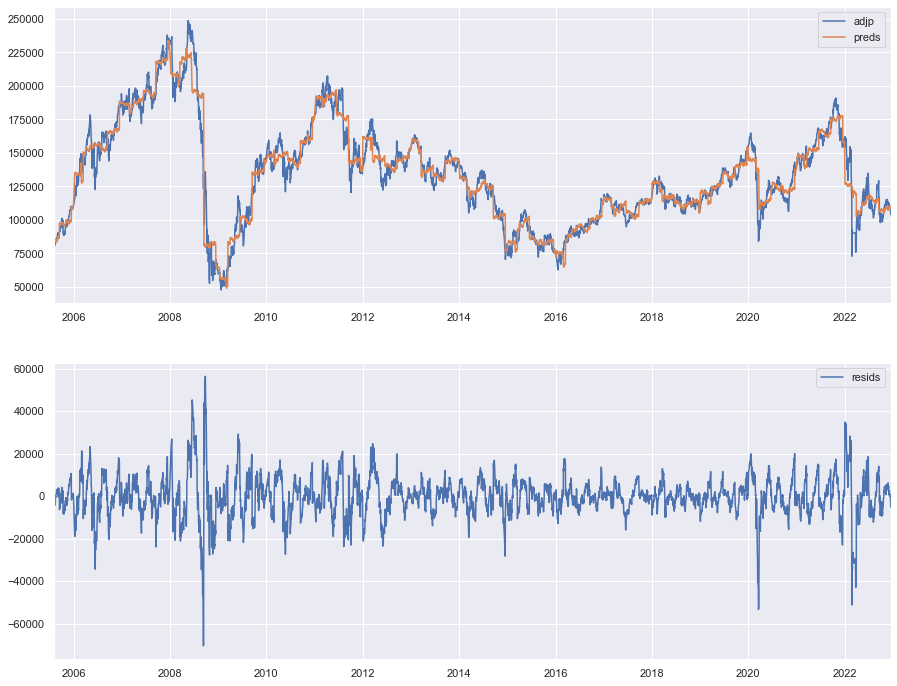

RMSE: 9623.19
R2: 0.93


In [104]:
fig, ax = plt.subplots(2, figsize = (15, 12))
y.plot(ax = ax[0], legend = True)
preds.plot(ax = ax[0])
resids.plot(ax = ax[1], label = 'resids')
plt.legend()
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y, preds)))

array([[<AxesSubplot:title={'center':'resids'}>]], dtype=object)

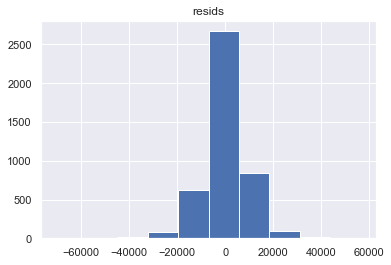

In [105]:
resids.hist()

In [106]:
resids.describe()

,resids
count,4.359000e+03
mean,-4.288058e-10
std,9.624297e+03
min,-7.039369e+04
25%,-4.825030e+03
50%,8.183177e+00
75%,4.795271e+03
max,5.647606e+04


In [107]:
resids.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4359 entries, 2005-08-03 to 2022-12-15
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   resids  4359 non-null   float64
dtypes: float64(1)
memory usage: 68.1 KB


/var/folders/lp/88x61zk54x96rfk1cnvrknb80000gn/T/ipykernel_69205/3651888821.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(resids['resids'])


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

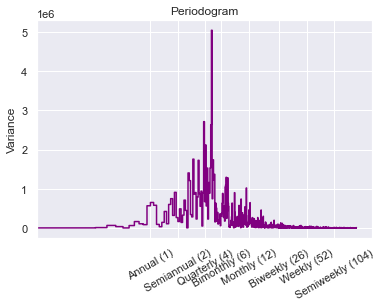

In [108]:
plot_periodogram(resids['resids'])

Применим комбинированные фичи на трейн / тесте (включая лаг по времени и календарные фичи).

In [109]:
data.columns

Index(['name', 'adjp', 'mov_5', 'mov_10', 'mov_20', 'mov_40', 'mov_60',
       'mov_120', 'mov_240', 'lag_1', 'dif_1', 'return', 'ln_r',
       'volatility_5', 'volatility_20', 'volatility_60', 'const', 'time_step',
       'year', 'month', 'day', 'day_of_week', 'sin_month', 'cos_month',
       'sin_day', 'cos_day', 'sin_dw', 'cos_dw'],
      dtype='object')

In [110]:
model = LinearRegression()

In [111]:
y = data[TARGET_COLUMN].dropna()

In [112]:
X = data[['lag_1', 'const', 'time_step',
       'year', 'month', 'sin_month', 'cos_month', 'day', 'sin_day', 'cos_day',
       'day_of_week', 'sin_dw', 'cos_dw']].dropna()

In [113]:
y, X = y.align(X, join='inner', axis = 0)

In [114]:
categorical_features = ['year', 'month', 'day', 'day_of_week']

In [115]:
numeric_features = ['lag_1', 'const', 'time_step', 'sin_month', 'cos_month', 'sin_day', 'cos_day',
                    'sin_dw', 'cos_dw']

In [116]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [117]:
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LinearRegression())])

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [119]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'const',
                                                   'time_step', 'sin_month',
                                                   'cos_month', 'sin_day',
                                                   'cos_day', 'sin_dw',
                                                   'cos_dw']),
                                                 ('cat',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['y

In [120]:
preds_train = pd.DataFrame(lr_pipe.predict(X_train), index = X_train.index, columns = ['preds'])

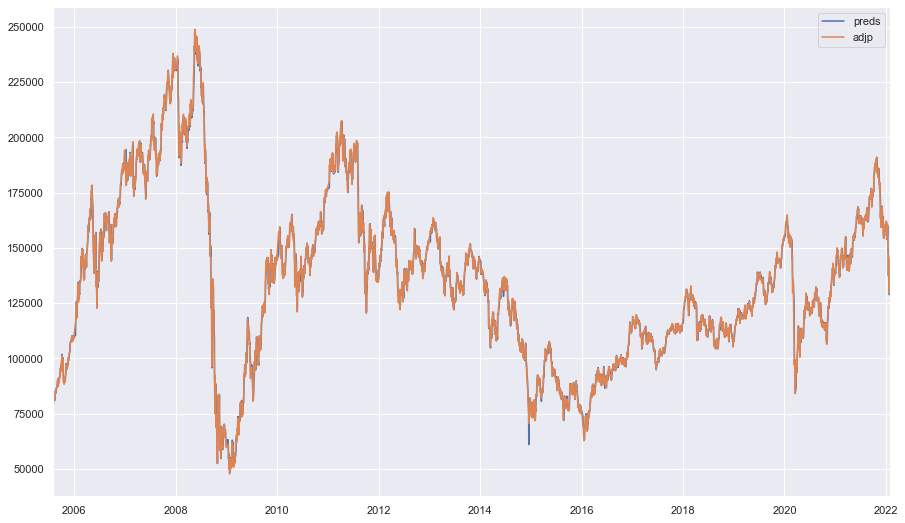

RMSE: 2703.02
R2: 0.99


In [121]:
f, ax = plt.subplots(figsize = (15, 9))
preds_train.plot(ax = ax, legend = True)
y_train.plot(ax = ax, legend = True)
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y_train, preds_train)**0.5))
print('R2: {:.2f}'.format(r2_score(y_train, preds_train)))

In [122]:
preds = pd.DataFrame(lr_pipe.predict(X_test), index = X_test.index, columns = ['preds'])

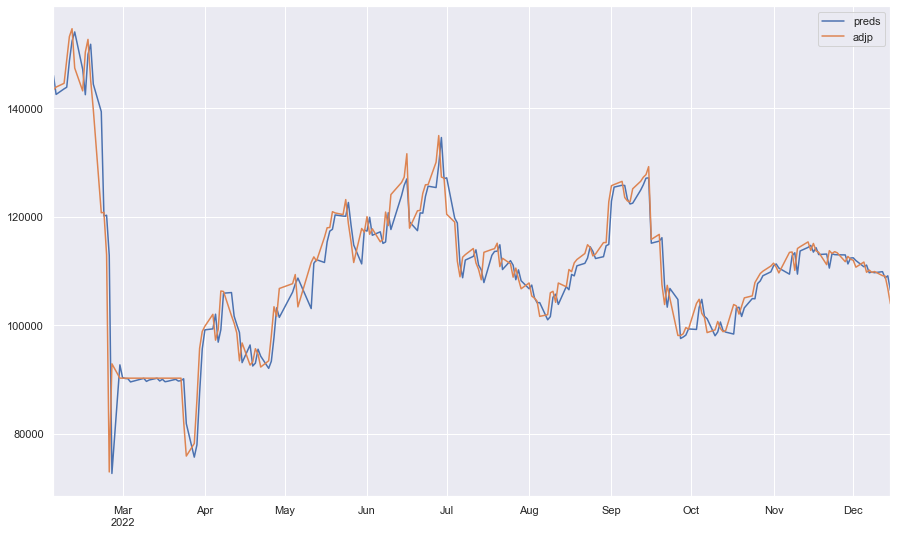

RMSE: 4495.60
R2: 0.90


In [123]:
f, ax = plt.subplots(figsize = (15, 9))
preds.plot(ax = ax, legend = True)
y_test.plot(ax = ax, legend = True)
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y_test, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y_test, preds)))

PCA

In [124]:
data.columns

Index(['name', 'adjp', 'mov_5', 'mov_10', 'mov_20', 'mov_40', 'mov_60',
       'mov_120', 'mov_240', 'lag_1', 'dif_1', 'return', 'ln_r',
       'volatility_5', 'volatility_20', 'volatility_60', 'const', 'time_step',
       'year', 'month', 'day', 'day_of_week', 'sin_month', 'cos_month',
       'sin_day', 'cos_day', 'sin_dw', 'cos_dw'],
      dtype='object')

In [125]:
y = data[TARGET_COLUMN].dropna()

In [126]:
X = data[['const', 'time_step',
       'year', 'month', 'sin_month', 'cos_month', 'day', 'sin_day', 'cos_day',
       'day_of_week', 'sin_dw', 'cos_dw', 'lag_1']].dropna()

In [127]:
y, X = y.align(X, join='inner', axis = 0)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

In [129]:
X_train.head()

,const,time_step,year,month,sin_month,cos_month,day,sin_day,cos_day,day_of_week,sin_dw,cos_dw,lag_1
2005-08-04,1.0,1,2005,8,-0.866025,-0.5,4,0.735417,0.677615,3,-1.000000e+00,-1.836970e-16,79810.0
2005-08-05,1.0,2,2005,8,-0.866025,-0.5,5,0.858764,0.512371,4,-2.449294e-16,1.000000e+00,80270.0
2005-08-08,1.0,3,2005,8,-0.866025,-0.5,8,0.996659,-0.081676,0,0.000000e+00,1.000000e+00,81050.0
2005-08-09,1.0,4,2005,8,-0.866025,-0.5,9,0.958718,-0.284359,1,1.000000e+00,6.123234e-17,81610.0
2005-08-10,1.0,5,2005,8,-0.866025,-0.5,10,0.880012,-0.474951,2,1.224647e-16,-1.000000e+00,81515.0


In [130]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4140, 13), (218, 13), (4140,), (218,))

In [131]:
X_train.index, X_test.index, y_train.index, y_test.index

(PeriodIndex(['2005-08-04', '2005-08-05', '2005-08-08', '2005-08-09',
              '2005-08-10', '2005-08-11', '2005-08-12', '2005-08-15',
              '2005-08-16', '2005-08-17',
              ...
              '2022-01-20', '2022-01-21', '2022-01-24', '2022-01-25',
              '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-31',
              '2022-02-01', '2022-02-02'],
             dtype='period[D]', length=4140),
 PeriodIndex(['2022-02-03', '2022-02-04', '2022-02-07', '2022-02-08',
              '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-14',
              '2022-02-15', '2022-02-16',
              ...
              '2022-12-02', '2022-12-05', '2022-12-06', '2022-12-07',
              '2022-12-08', '2022-12-09', '2022-12-12', '2022-12-13',
              '2022-12-14', '2022-12-15'],
             dtype='period[D]', length=218),
 PeriodIndex(['2005-08-04', '2005-08-05', '2005-08-08', '2005-08-09',
              '2005-08-10', '2005-08-11', '2005-08-12', '2005-08-15',
   

In [132]:
categorical_features = ['year', 'month', 'day', 'day_of_week']

In [133]:
numeric_features = ['lag_1', 'const', 'time_step', 'sin_month', 'cos_month', 'sin_day', 'cos_day',
                    'sin_dw', 'cos_dw']

In [134]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

In [135]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['lag_1', 'const', 'time_step', 'sin_month',
                                  'cos_month', 'sin_day', 'cos_day', 'sin_dw',
                                  'cos_dw']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['year', 'month', 'day', 'day_of_week'])])

In [136]:
preprocessor.transform(X_train)

<4140x73 sparse matrix of type '<class 'numpy.float64'>'
	with 48348 stored elements in Compressed Sparse Row format>

In [137]:
preprocessor.transform(X_test)

<218x73 sparse matrix of type '<class 'numpy.float64'>'
	with 2567 stored elements in Compressed Sparse Row format>

In [138]:
pca = PCA()

In [139]:
pca.fit(X_train)

PCA()

In [140]:
pca.explained_variance_

array([1.40042232e+09, 1.30475555e+06, 7.61559338e+01, 1.21422015e+01,
       2.11020353e+00, 5.58634745e-01, 5.15164609e-01, 4.79721820e-01,
       3.16736554e-01, 1.95639973e-01, 1.80781274e-01, 2.01738515e-04,
       0.00000000e+00])

In [141]:
pca.feature_names_in_

array(['const', 'time_step', 'year', 'month', 'sin_month', 'cos_month',
       'day', 'sin_day', 'cos_day', 'day_of_week', 'sin_dw', 'cos_dw',
       'lag_1'], dtype=object)

In [142]:
pca.explained_variance_ratio_

array([9.99069114e-01, 9.30819909e-04, 5.43300691e-08, 8.66231445e-09,
       1.50543100e-09, 3.98533151e-10, 3.67521313e-10, 3.42236230e-10,
       2.25961629e-10, 1.39570651e-10, 1.28970372e-10, 1.43921385e-13,
       0.00000000e+00])

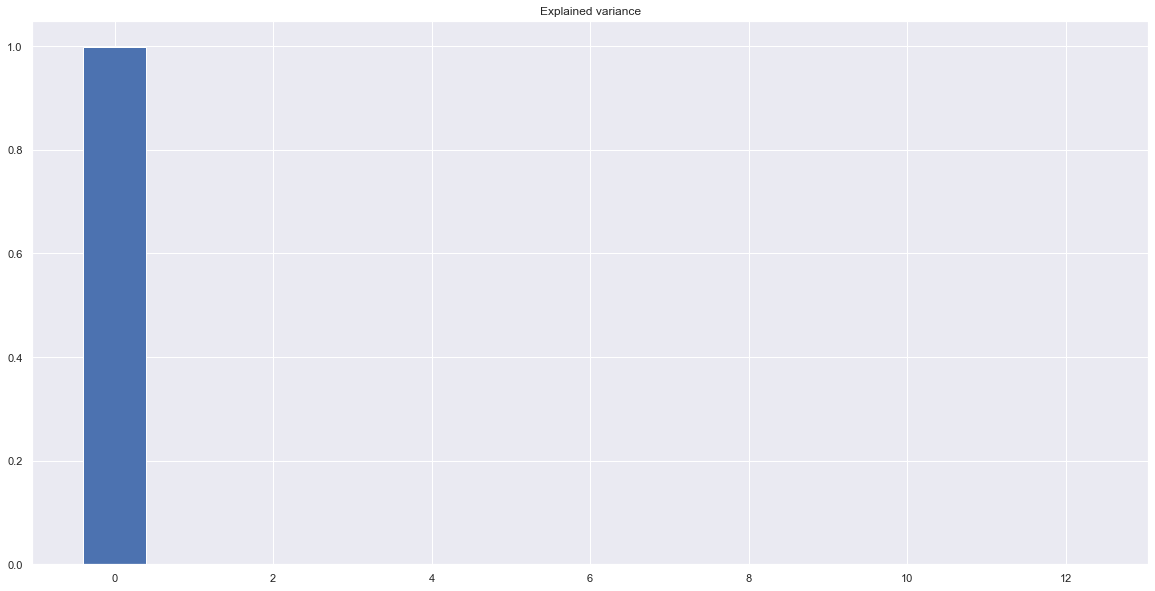

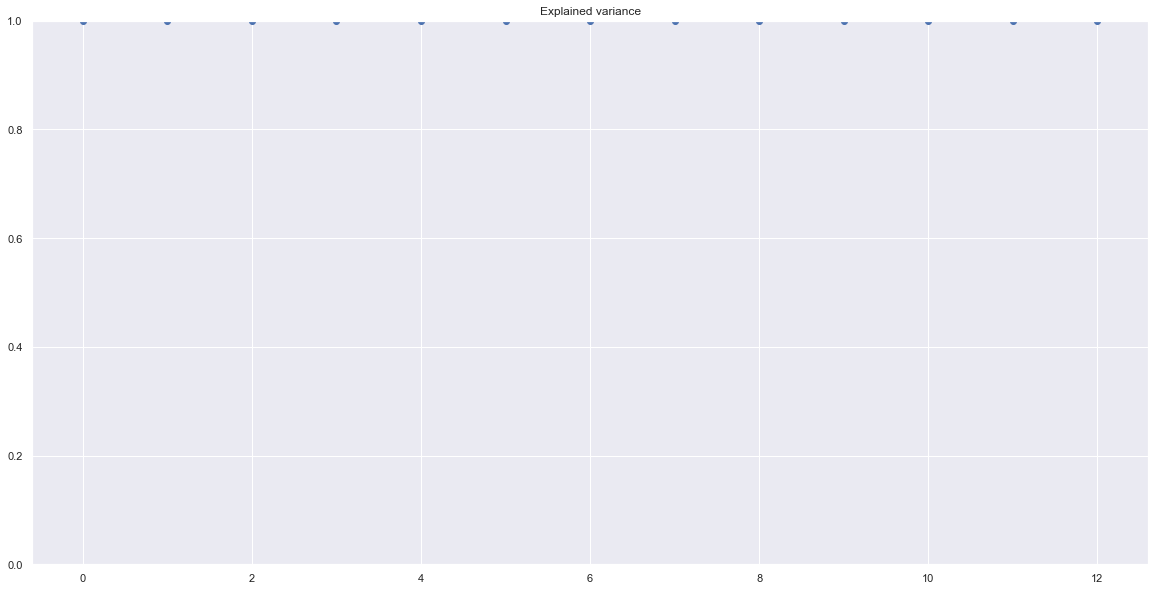

In [143]:
plt.figure(figsize=(20,10))
plt.bar(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.ylim(0)
plt.title('Explained variance')
plt.show()
plt.figure(figsize=(20,10))
plt.plot(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_.cumsum(), '-o')
plt.ylim(0)
plt.title('Explained variance')
plt.show()

In [147]:
pca = PCA(n_components=13)

In [148]:
pca.fit(X_train)

PCA(n_components=13)

In [149]:
X_train_pca = pca.transform(X_train)

In [150]:
X_train_pca

array([[-5.48322529e+04,  2.58670489e+03,  1.23011222e+01, ...,
        -4.27678317e-01,  3.55296548e-02,  0.00000000e+00],
       [-5.43722827e+04,  2.58137549e+03,  1.13121667e+01, ...,
        -3.81809565e-01,  3.56243199e-02,  0.00000000e+00],
       [-5.35923267e+04,  2.57303434e+03,  8.32585412e+00, ...,
        -2.08782303e-01,  3.57911004e-02,  0.00000000e+00],
       ...,
       [ 5.70611654e+03, -2.12132466e+03, -1.51477405e+01, ...,
        -3.37550693e-01,  3.04510919e-02,  0.00000000e+00],
       [ 8.93596409e+03, -2.15272722e+03,  1.48028542e+01, ...,
        -3.80706939e-01,  3.55648395e-02,  0.00000000e+00],
       [ 1.10758599e+04, -2.17386879e+03,  1.38156241e+01, ...,
        -2.93796881e-01,  3.55959116e-02,  0.00000000e+00]])

In [151]:
X_test_pca = pca.transform(X_test)

In [152]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

LinearRegression()

In [153]:
preds = pd.DataFrame(lr_pca.predict(X_test_pca), index = X_test.index, columns = ['preds'])

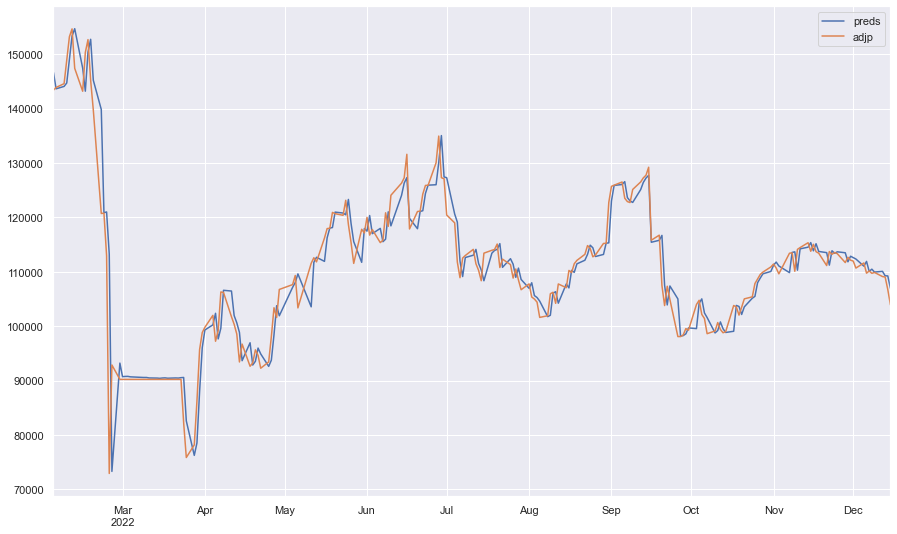

RMSE: 4479.88
R2: 0.90


In [154]:
f, ax = plt.subplots(figsize = (15, 9))
preds.plot(ax = ax, legend = True)
y_test.plot(ax = ax, legend = True)
plt.show()
print('RMSE: {:.2f}'.format(mean_squared_error(y_test, preds)**0.5))
print('R2: {:.2f}'.format(r2_score(y_test, preds)))